## Feature Extraction

#### Initial convolutional layer - resnet.conv1 (Conv2d)

Applies a 2D convolution over an input signal composed of several input planes.

In the simplest case, the output value of the layer with input size
$`(N, C_{\text{in}}, H, W)`$ and output $`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`$
can be precisely described as:

$$
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$$

where $`\star`$ is the valid 2D `cross-correlation`_ operator,
$`N`$ is a batch size, $`C`$ denotes a number of channels,
$`H`$ is a height of input planes in pixels, and $`W`$ is
width in pixels.


#### Batch normalization - resnet.bn1 (BatchNorm2d)

Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper `Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift <https://arxiv.org/abs/1502.03167>

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

#### Activation function - ReLU

$$\text{ReLU}(x) = (x)^+ = \max(0, x)$$

#### Max pooling - resnet.maxpool (_MacPoolNd)

Applies a 2D max pooling over an input signal composed of several input planes.

In the simplest case, the output value of the layer with input size (N, C, H, W),
output (N, C, H_{out}, W_{out}) and `kernel_size` `(kH, kW)`
can be precisely described as:

$$
\begin{aligned}
            out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
                                    & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
                                                   \text{stride[1]} \times w + n)
        \end{aligned}
$$

https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

# Padim Example

#### Import dependencies

In [1]:
import os
import anodet
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 

## Training

In this notebook the MVTec dataset will be used. It can be downloaded from: https://www.mvtec.com/company/research/datasets/mvtec-ad.

Change `DATASET_PATH` to the path where you save the dataset.

Also, if you want to save and load the model. Add a folder where to save them and change the path of `MODEL_DATA_PATH` to that folder.

In [2]:
DATASET_PATH = os.path.realpath("../../data/mvtec_dataset/")
MODEL_DATA_PATH = os.path.realpath("./distributions/")

#### Load dataset

In [3]:
dataset = anodet.AnodetDataset(os.path.join(DATASET_PATH, "bottle/train/good"))
dataloader = DataLoader(dataset, batch_size=32)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [4]:
padim = anodet.Padim(backbone='resnet18')

#### Fit the model to the dataset

In [5]:
padim.fit(dataloader)

Feature extraction:   0%|          | 0/7 [00:00<?, ?it/s]

Feature extraction: 100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


#### Save the necessary parameters

In [6]:
distributions_path = './distributions/'
torch.save(padim.mean, os.path.join(MODEL_DATA_PATH, "2bottle_mean.pt"))
torch.save(padim.cov_inv, os.path.join(MODEL_DATA_PATH, "2bottle_cov_inv.pt"))

# 

## Inference
#### Load test images

In [7]:
paths = [
    os.path.join(DATASET_PATH, "bottle/test/broken_large/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/broken_small/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/contamination/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/good/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/good/001.png"),
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the model data

In [8]:
mean = torch.load(os.path.join(MODEL_DATA_PATH, '2bottle_mean.pt'))
cov_inv = torch.load(os.path.join(MODEL_DATA_PATH, '2bottle_cov_inv.pt'))

#### init the model

In [9]:
padim = anodet.Padim(backbone='resnet18', mean=mean, cov_inv=cov_inv, device=torch.device('cpu'))

#### Make prediction

In [10]:
image_scores, score_maps = padim.predict(batch)

#### Interpret the prediction

In [11]:
THRESH = 13
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([26.2478, 21.5471, 23.0032, 10.2540,  9.6295])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualization

In [12]:
test_images = np.array(images).copy()

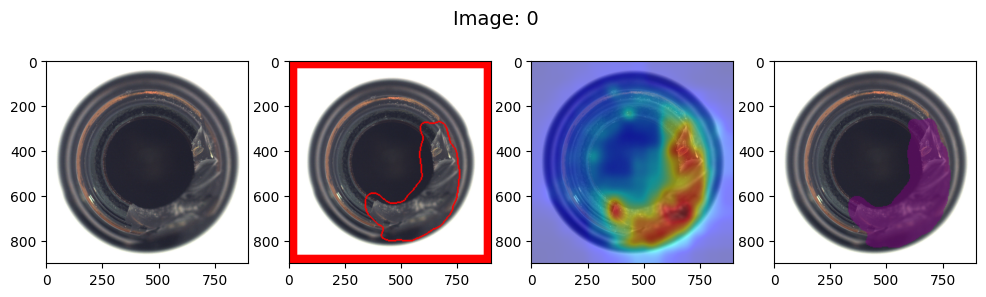

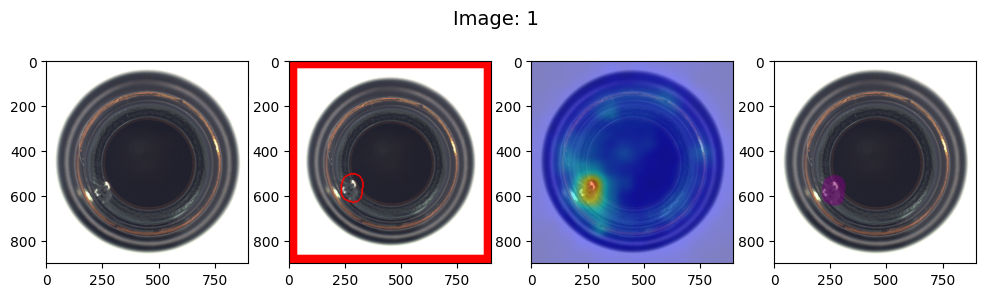

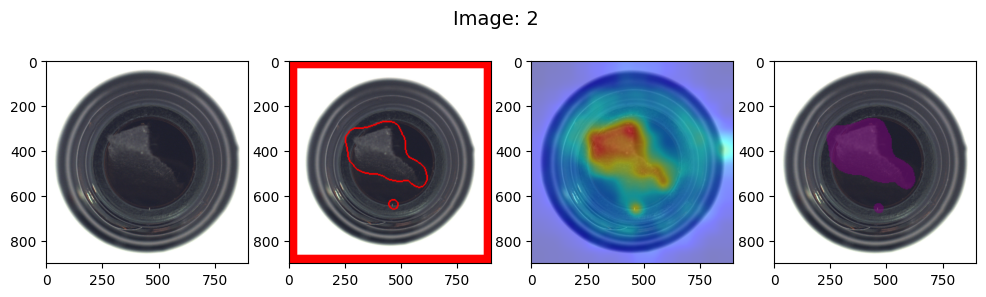

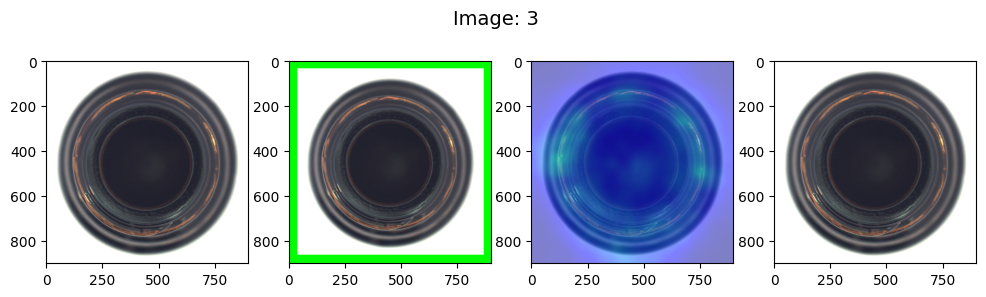

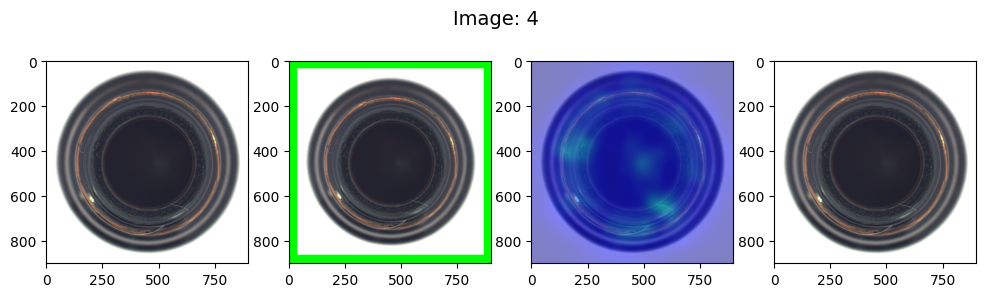

In [13]:
boundary_images = anodet.visualization.framed_boundary_images(test_images, score_map_classifications, image_classifications, padding=40)
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
highlighted_images = anodet.visualization.highlighted_images(images, score_map_classifications, color=(128, 0, 128))

for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle('Image: ' + str(idx), y=0.75, fontsize=14)
    axs[0].imshow(images[idx])
    axs[1].imshow(boundary_images[idx])
    axs[2].imshow(heatmap_images[idx])
    axs[3].imshow(highlighted_images[idx])
    plt.show()

#### For one merged image

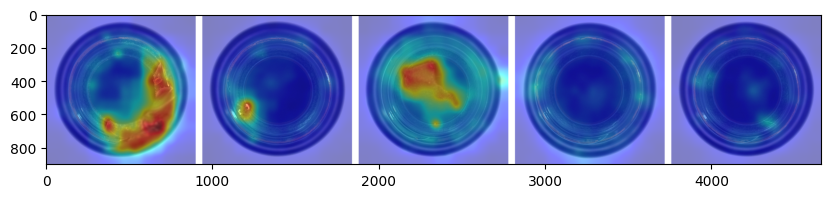

In [14]:
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
tot_img = anodet.visualization.merge_images(heatmap_images, margin=40)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.imshow(tot_img)
plt.show()